In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest, shapiro, anderson, cramervonmises

In [2]:
#1
def mean_vector(data):
    ones=pd.DataFrame({'ones': np.ones(len(data))})
    mean=ones.transpose().dot(data)/len(data)
    return mean

def covariance_matrix(data):
    mean=mean_vector(data)
    mean_rep = pd.concat([mean]*len(data))
    mean_rep.columns=data.columns
    mean_rep.reset_index(inplace = True, drop = True)
    covariance=(data-mean_rep).transpose().dot(data-mean_rep)/(len(data)-1)
    return covariance

def sample_corr_matrix(data):
    S = covariance_matrix(data)
    Si, Sj = S.copy(), S.copy()
    for i in range(len(Si)):
        Si.iloc[i,:]=S.iloc[i,i]
    for j in range(len(Sj)):
        Sj.iloc[:,j]=S.iloc[j,j]
    
    R=S/np.sqrt(Si)/np.sqrt(Sj)
    return R

def standardize(data):
    X = data
    p = len(data)
    mu=pd.concat([mean_vector(data)]*len(data), ignore_index = True)
    S=covariance_matrix(data)
    
    #V^(-1/2)
    V = pd.DataFrame(0, index=np.arange(len(S)),columns = range(len(S))) 
    for i in range(len(S)):
        V.iloc[i,i] = 1/np.sqrt(S.iloc[i,i])
    V.index, V.columns = data.columns, data.columns
    
    Z=(V.dot((X-mu).T)).T
    return Z

In [3]:
class PCA_corr:
    def __init__(self, data):
        self.data = data
        self.R = sample_corr_matrix(self.data)
        self.eigval, self.eigvec = np.linalg.eig(self.R)
        self.p = len(self.data.T) #number of original variables
    
    #(a) PCA on correlation matrix
    def analysis(self):
        #sort
        self.order = np.argsort(self.eigval)[::-1]
        self.eigval = self.eigval[self.order]
        self.eigvec = self.eigvec[:,self.order]
        
        #principal components matrix
        self.PC = pd.DataFrame(index = self.data.columns, columns = ['Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8'])
        for i in range(self.p):
            self.PC.iloc[:,i]=self.eigvec[i]
        
        return self.PC
    
    #(b) Proportion of variance explained by principal components
    def prop_var(self):
        prop = pd.DataFrame(index=range(self.p), columns=['eigenvalues', 'proportion', 'cumulative'])
        prop['eigenvalues'] = self.eigval
        prop['proportion'] = self.eigval/self.p
        
        prop.loc[0,'cumulative']=prop.loc[0,'proportion']
        for i in range(1,self.p):
            prop.loc[i,'cumulative']=prop.loc[i,'proportion']+prop.loc[i-1,'cumulative']
        
        return prop
    
    #(c) Scree plot
    def scree_plt(self):
        plt.title('Scree Plot of Eigenvalues')
        plt.xlabel('Number')
        plt.plot(self.eigval, 'o-')
        plt.show()
        
    #(d) PC Scores
    def PC_score(self, PC_num):
        self.score = pd.DataFrame(index=range(len(self.data)), columns = ['Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8'])
        self.Z = standardize(self.data)
        for i in range(len(self.score.columns)):           
            self.score.iloc[:,i] = self.eigvec[:,i].dot(self.Z.T)
        return self.score.iloc[:,:PC_num]

In [4]:
#2
navy = pd.read_csv('navy.dat', header = None, delim_whitespace=True)
navy.columns = ['ID', 'ADO', 'MAC', 'WHR', 'CUA', 'WNGS', 'OBC', 'RMS', 'MMH']

data = navy.iloc[:,1:] # remove ID column
#Add '1' to variable containing zero
data.iloc[:,3]=data.iloc[:,3]+1
data=np.log(data)
data

,ADO,MAC,WHR,CUA,WNGS,OBC,RMS,MMH
0,0.693147,1.386294,1.386294,0.815365,0.000000,1.791759,1.791759,5.194234
1,1.098612,0.457425,3.688879,0.810930,0.000000,1.609438,1.609438,5.207353
2,2.809403,3.168845,3.688879,0.693147,0.000000,2.564949,2.564949,5.102181
3,1.945910,0.862890,5.123964,0.693147,0.000000,1.945910,2.079442,5.650909
4,1.667707,0.512824,3.749504,2.173615,1.098612,3.218876,3.218876,5.297917
5,2.803360,2.110213,5.123964,0.751416,0.693147,2.944439,2.944439,5.588671
6,3.253857,1.098612,3.688879,0.000000,1.098612,3.583519,3.583519,6.906845
7,3.793690,5.073610,5.123964,0.470004,2.890372,3.871201,3.871201,7.006007
8,3.679586,3.929077,3.688879,3.345332,2.302585,4.343805,4.343805,6.850349
9,3.463233,3.690877,5.123964,1.874874,1.791759,3.850148,3.850148,6.837161


In [5]:
#initiate
PCA_navy = PCA_corr(data)

In [6]:
#(a) PCA on correlation matrix
PCA = PCA_navy.analysis()
PCA

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8
ADO,-0.373020,-0.360289,-0.275727,-0.318853,-0.357864,-0.376906,-0.380274,-0.372321
MAC,-0.107594,-0.023598,-0.863570,0.439212,0.124525,0.134437,0.124512,0.011066
WHR,-0.220503,-0.128714,0.384548,0.805176,-0.231831,-0.061904,-0.064751,-0.277228
CUA,-0.157743,-0.717924,0.141830,-0.041530,0.641783,0.088827,0.124557,-0.050707
WNGS,0.250931,-0.466126,-0.025390,-0.093121,-0.596117,0.456799,0.382212,0.018382
OBC,-0.036979,-0.279348,-0.000481,0.152192,-0.163712,-0.333877,-0.176688,0.853194
RMS,0.839078,-0.199899,-0.097884,0.149238,0.083474,-0.363990,-0.188948,-0.221309
MMH,-0.085963,0.048830,0.001324,-0.035868,-0.040877,-0.612796,0.779215,-0.067618


In [7]:
#(b) How many PCs required to adequately describe the space in which these data actually fall?
PCA_navy.prop_var()

,eigenvalues,proportion,cumulative
0,6.674089,0.834261,0.834261
1,0.592580,0.074073,0.908334
2,0.313358,0.039170,0.947503
3,0.187037,0.023380,0.970883
4,0.112785,0.014098,0.984981
5,0.065302,0.008163,0.993144
6,0.053104,0.006638,0.999782
7,0.001744,0.000218,1.0


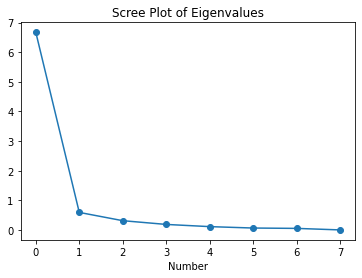

In [8]:
PCA_navy.scree_plt()
#elbow is at index=1
#Only one principal component (index=0) is required

In [9]:
#(c) Calculate principal component scores
PCA_navy.PC_score(1)

,Y1
0,5.380969
1,4.824661
2,3.470424
3,3.763104
4,2.991037
5,2.594652
6,2.369429
7,0.255922
8,0.115610
9,0.607836


In [10]:
#(d) Calculate correlations between variables(Z) and PC scores(Y)
corr = pd.DataFrame(PCA_navy.eigvec.copy(), index = ['Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8'], columns = ['Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8'])
for i in range(8):
    corr.iloc[:,i]=corr.iloc[:,i]*np.sqrt(PCA_navy.eigval[i])
corr

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8
Z1,-0.963669,-0.082825,-0.123434,-0.068221,0.084271,-0.009450,0.193360,-0.003590
Z2,-0.930779,-0.018165,-0.072052,-0.310486,-0.156542,-0.071385,-0.046065,0.002039
Z3,-0.712319,-0.664770,0.215264,0.061338,-0.008527,-0.000123,-0.022557,0.000055
Z4,-0.823733,0.338102,0.450725,-0.017961,-0.031273,0.038892,0.034391,-0.001498
Z5,-0.924516,0.095858,-0.129775,0.277557,-0.200197,-0.041835,0.019236,-0.001707
Z6,-0.973709,0.103489,-0.034653,0.038416,0.153409,-0.085320,-0.083879,-0.025590
Z7,-0.982409,0.095848,-0.036247,0.053868,0.128360,-0.045151,-0.043542,0.032540
Z8,-0.961863,0.008518,-0.155188,-0.021930,0.006173,0.218028,-0.050999,-0.002824


In [11]:
#(e) Is there any evidence that the data do not follow a multivariate normal distribution? Answer the question using PC scores.
x = PCA_navy.PC_score(1).iloc[:,0]
x

0     5.380969
1     4.824661
2     3.470424
3     3.763104
4     2.991037
5     2.594652
6     2.369429
7     0.255922
8     0.115610
9     0.607836
10   -1.202995
11    0.206310
12   -1.251468
13   -0.193598
14   -1.764154
15   -1.954653
16   -1.644965
17   -2.787862
18   -1.455821
19   -1.790250
20   -1.561804
21   -3.386554
22   -2.712675
23   -3.154529
24   -1.718625
Name: Y1, dtype: float64

In [12]:
#mean and standard deviation
m = x.mean()
s = x.std()

In [13]:
print("Shapiro-Wilk:",shapiro(x),"\n")
print("Kolmogoroc-Smirnov:",kstest(x, 'norm', args = (m,s)),"\n")
print("Cramer-von Mises:",cramervonmises(x, 'norm', args = (m,s)),"\n")
print("Anderson-Darling:",anderson(x, 'norm'))

#The tests are conducted under the null hypothesis that the principal component score follows a normal distribution.
#If the data follows a multivariate normal distribution, its principal components should follow a univariate normal distribution.
#From Kolmogoroc-Smirnov, Cramer-von Mises, and Anderson-Darling tests, by observing the p-values and test statistic, we cannot reject the null hypothesis.
#We conclude that the data follows a multivariate normal distribution.

Shapiro-Wilk: ShapiroResult(statistic=0.9071464538574219, pvalue=0.026336275041103363) 

Kolmogoroc-Smirnov: KstestResult(statistic=0.19927007628143245, pvalue=0.239925809351193) 

Cramer-von Mises: CramerVonMisesResult(statistic=0.16719470124004313, pvalue=0.3427804517896553) 

Anderson-Darling: AndersonResult(statistic=0.927302602507396, critical_values=array([0.514, 0.586, 0.703, 0.82 , 0.975]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
